In [1]:
import torch
from torch import distributions as dist

import itertools
import pickle
import importlib

import random
import math
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('paper')
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'axes.labelsize': 20})
plt.rcParams.update({'legend.fontsize': 12})
plt.rcParams.update({'axes.titlesize': 16})

from gptorch import kernels, models
import helpers, opt, objectives

In [2]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [3]:
with open('../inputs/phoq.pkl', 'rb') as f:
    t = pickle.load(f)
X = t[0]
A = t[2]
y = t[3].values
wt = helpers.decode_X(X[150614])  # wt as string
aas = 'ARNDCQEGHILKMFPSTWYV'

ground = [(aa, i) for aa in aas for i in range(4)]
L = 4

In [4]:
seq_to_x = {}
for i, x in enumerate(X):
    seq = helpers.decode_X(x)
    seq_to_x[seq] = i
wt_inds = [seq_to_x[wt]]

In [6]:
singles = [wt[:i] + aas[j] + wt[i+1:] for i in range(4) for j in range(20)]
wt_inds = [seq_to_x[wt]]
single_inds = wt_inds + [seq_to_x[seq] for seq in singles]

In [34]:
np.random.seed(120120)
_ = torch.manual_seed(43298)



n = 100
train_inds = wt_inds + single_inds + list(np.random.choice(len(X), n, replace=True))


y_true = y
A_test = A

sampled_inds = [train_inds[:]]
libs = []
objs = []

for it in range(3):
    inds = sorted(set(train_inds))
    print(len(inds))
    dic, _ = helpers.get_predictions(A[inds], y[inds], A_test,
                                     one_hots=X, its=3000, lr=1e-2)
    print()
    seen_seqs = [helpers.decode_X(X[i]) for i in inds]
    for s in seen_seqs:
        dic[s] = 0.0
    seed = helpers.get_seed(dic)
    sets_seed, objs_seed = opt.greedy(ground, seed, objectives.objective, depth=1, obj_args=(L, dic, n))
    sets_grou, objs_grou = opt.greedy(ground, ground, objectives.objective, depth=1, obj_args=(L, dic, n))
    if objs_grou[-1] < objs_seed[-1]:
        X_new = sets_grou[-1]
        objs.append(objs_grou[-1])
    else:
        X_new = sets_seed[-1]
        objs.append(objs_seed[-1])
    new_lib = helpers.seqs_from_set(X_new, L)
    inds = np.random.choice(len(new_lib), n, replace=True)
    sampled_seqs = [new_lib[i] for i in inds]
    inds = [seq_to_x[s] for s in sampled_seqs]
    sampled_inds.append(inds)
    train_inds += inds
    libs.append(X_new)
    
    

177
Iteration 3000 of 3000	NLML: 58.9343	sn: 0.259592	
253
Iteration 3000 of 3000	NLML: 19.3091	sn: 0.079247	
314
Iteration 3000 of 3000	NLML: -6.1223	sn: 0.089226	


In [41]:
df = pd.DataFrame(np.power(10, np.concatenate([y[i] for i in sampled_inds])), columns=['y'])
df['round'] = [0] * (182) + [1] * n + [2] * n + [3] * n 
df.head()

,y,round
0,0.001042,0
1,0.001042,0
2,0.001042,0
3,0.000010,0
4,0.000608,0


TDCW


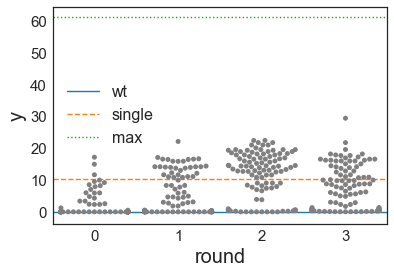

In [75]:
bounds = [-0.5, 3.5]
_ = plt.plot(bounds, [10 ** y[seq_to_x[wt]], 10 ** y[seq_to_x[wt]]], label='wt')
baseline = ''
for i in range(4):
    seqs = [wt[:i] + a + wt[i + 1:] for a in aas]
    inds = [seq_to_x[s] for s in seqs]
    baseline += aas[np.argmax(y[inds])]
print(baseline)
baseline = 10 ** y[seq_to_x[baseline]]
_ = plt.plot(bounds, [baseline, baseline], '--', label='single')
_ = plt.plot(bounds, [10 ** np.max(y), 10 ** np.max(y)], ':', label='max')
_ = sns.swarmplot(data=df, x='round', y='y', color='grey')
_ = plt.legend()


In [70]:
results = {
    'df':df,
    'sampled_inds': sampled_inds,
    'libs':libs,
    'objs': objs
}

In [72]:
with open('../outputs/20181003_phoq_batches.pkl', 'wb') as f:
    pickle.dump(results, f)

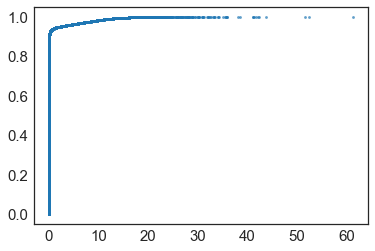

In [73]:
_ = plt.plot(np.sort(10 ** y), np.linspace(0, 1, len(y)), '.', alpha=0.7)

In [76]:
df = pd.DataFrame(10 ** y, columns=['f'])
df['round'] = [-1 for _ in df.index]
for r, inds in enumerate(sampled_inds):
    for i in inds:
        if df.loc[i, 'round'] == -1:
            df.loc[i, 'round'] = r

df['single'] = [1 if i in single_inds else 0 for i in df.index]
df['wt'] = [0 for i in df.index]
df.loc[wt_inds]['wt'] = 1
df['sorted'] = np.linspace(0, 1, len(y))[np.argsort(np.argsort(df['f']))]
df['baseline'] = [0 for _ in df.index]
baseline = ''
for i in range(4):
    seqs = [wt[:i] + a + wt[i + 1:] for a in aas]
    inds = [seq_to_x[s] for s in seqs]
    baseline += aas[np.argmax(y[inds])]
df.loc[seq_to_x[baseline], 'baseline'] = 1

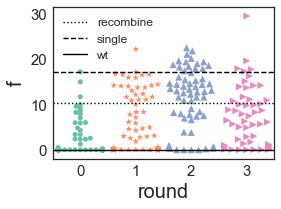

In [109]:
pal = sns.color_palette('Set2')
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
for mark, r in zip(['o', '*', '^', '>'], range(4)):
    dat = df[df['round'] == r]
    temp = pd.DataFrame(np.array([[0, 1, 2, 3]]).T, columns=['round'])
    dat = dat.append(temp)
    if r == 0:
        s = 5
    else:
        s = 7
    ax = sns.swarmplot(data=dat, x='round', y='f', color=pal[r], ax=ax, zorder=0, marker=mark, size=s)

# ax = sns.swarmplot(data=df[df['round'] == 1], x='round', y='f', color=pal[1], ax=ax, zorder=0, marker='*')
_ = ax.plot([-0.5, 3.5], [df[df['baseline'] == 1]['f'].values] * 2, ':', label='recombine', color='black')
_ = ax.plot([-0.5, 3.5], [np.max(10 ** y[single_inds])] * 2, '--', color='black', label='single')
_ = ax.plot([-0.5, 3.5], [np.max(10 ** y[wt_inds])] * 2, color='black', label='wt')
_ = ax.legend()
_ = fig.tight_layout()
_ = fig.savefig('../outputs/phoq_batches.pdf')

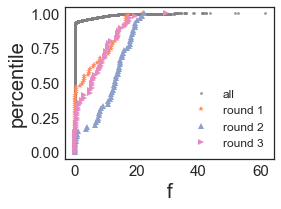

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
f = df['f'].values
p = df['sorted'].values
inds = list(np.argsort(f))
thinned = inds[:-1000:10] + inds[-1000:]
f_thinned = f[thinned] 
p_thinned = p[thinned] 
_ = ax.plot(f_thinned, p_thinned, '.', color='grey', alpha=0.8, label='all')
for c, r, s in zip(pal[1:], range(1, 4), ['*', '^', '>']):
    df_ = df[df['round'] == r]
    _ = ax.plot(np.sort(df_['f']), np.linspace(0, 1, len(df_)), s, label='round ' + str(r), 
                color=c)
_ = ax.legend()
_ = ax.set_xlabel('f')
_ = ax.set_ylabel('percentile')
_ = fig.tight_layout()
_ = fig.savefig('../outputs/phoq_ecdf.pdf')

In [87]:
df[df['round'] == 3].sort_values('f').tail()

,f,round,single,wt,sorted,baseline
100352,17.259640,3,0,0,0.996675,0
100427,17.699910,3,0,0,0.997000,0
124351,17.883912,3,0,0,0.997137,0
18839,19.597984,3,0,0,0.998075,0
146709,29.449178,3,0,0,0.999731,0


In [22]:
%%time 
for n in [50, 75, 100, 200]:
    np.random.seed(12120)
    _ = torch.manual_seed(4328)

    singles = [wt[:i] + aas[j] + wt[i+1:] for i in range(4) for j in range(20)]
    wt_inds = [seq_to_x[wt]]
    single_inds = wt_inds + [seq_to_x[seq] for seq in singles]
    train_inds = wt_inds + list(np.random.choice(len(X), n, replace=True)) # + single_inds


    y_true = y
    A_test = A

    sampled_inds = [train_inds[:]]
    libs = []
    objs = []

    rounds = 400 // n - 1

    for it in range(rounds):
        inds = sorted(set(train_inds))
        print(len(inds))
        dic, _ = helpers.get_predictions(A[inds], y[inds], A_test,
                                         one_hots=X, its=3000, lr=1e-2, sn=0.5)
        print()
        seen_seqs = [helpers.decode_X(X[i]) for i in inds]
        for s in seen_seqs:
            dic[s] = 0.0
        seed = helpers.get_seed(dic)
        sets_seed, objs_seed = opt.greedy(ground, seed, objectives.objective, depth=1, obj_args=(L, dic, n))
        sets_grou, objs_grou = opt.greedy(ground, ground, objectives.objective, depth=1, obj_args=(L, dic, n))
        if objs_grou[-1] < objs_seed[-1]:
            X_new = sets_grou[-1]
            objs.append(objs_grou[-1])
        else:
            X_new = sets_seed[-1]
            objs.append(objs_seed[-1])
        new_lib = helpers.seqs_from_set(X_new, L)
        inds = np.random.choice(len(new_lib), n, replace=True)
        sampled_seqs = [new_lib[i] for i in inds]
        inds = [seq_to_x[s] for s in sampled_seqs]
        sampled_inds.append(inds)
        train_inds += inds
        libs.append(X_new)

    df = pd.DataFrame(10 ** y, columns=['f'])
    df['round'] = [-1 for _ in df.index]
    for r, inds in enumerate(sampled_inds):
        for i in inds:
            if df.loc[i, 'round'] == -1:
                df.loc[i, 'round'] = r

    df['single'] = [1 if i in single_inds else 0 for i in df.index]
    df['wt'] = [0 for i in df.index]
    df.loc[wt_inds]['wt'] = 1
    df['sorted'] = np.linspace(0, 1, len(y))[np.argsort(np.argsort(df['f']))]
    df['baseline'] = [0 for _ in df.index]
    baseline = ''
    for i in range(4):
        seqs = [wt[:i] + a + wt[i + 1:] for a in aas]
        inds = [seq_to_x[s] for s in seqs]
        baseline += aas[np.argmax(y[inds])]
    df.loc[seq_to_x[baseline], 'baseline'] = 1

    results = {
        'df':df,
        'sampled_inds': sampled_inds,
        'libs':libs,
        'objs': objs
    }

    with open('../outputs/20181018_phoq_batches' + str(rounds + 1) + '.pkl', 'wb') as f:
        pickle.dump(results, f)

    

51
Iteration 3000 of 3000	NLML: 25.5000	sn: 0.250000	
101
Iteration 3000 of 3000	NLML: 50.5000	sn: 0.250000	
151
Iteration 3000 of 3000	NLML: 75.5000	sn: 0.250000	
201
Iteration 3000 of 3000	NLML: 88.2212	sn: 0.394397	
238
Iteration 3000 of 3000	NLML: 19.5124	sn: 0.000001	
270
Iteration 3000 of 3000	NLML: -14.3351	sn: 0.000001	
298
Iteration 3000 of 3000	NLML: -49.2168	sn: 0.000001	
76
Iteration 3000 of 3000	NLML: 33.9955	sn: 0.089414	


KeyboardInterrupt: 

In [25]:
df = pd.DataFrame(10 ** y, columns=['f'])
ns = [10, 50, 75, 100, 200]

for n in ns:
    col = 'round' + str(n)
    df[col] = [-1 for _ in df.index]
    rounds = 400 // n - 1
    with open('../outputs/20181018_phoq_batches' + str(rounds + 1) + '.pkl', 'rb') as f:
        results = pickle.load(f)
    for r, inds in enumerate(results['sampled_inds']):
        for i in inds:
            if df.loc[i, col] == -1:
                df.loc[i, col] = r
        
df['single'] = [1 if i in single_inds else 0 for i in df.index]
df['wt'] = [0 for i in df.index]
df.loc[wt_inds]['wt'] = 1
df['sorted'] = np.linspace(0, 1, len(y))[np.argsort(np.argsort(df['f']))]
df['baseline'] = [0 for _ in df.index]
baseline = ''
for i in range(4):
    seqs = [wt[:i] + a + wt[i + 1:] for a in aas]
    inds = [seq_to_x[s] for s in seqs]
    baseline += aas[np.argmax(y[inds])]
df.loc[seq_to_x[baseline], 'baseline'] = 1

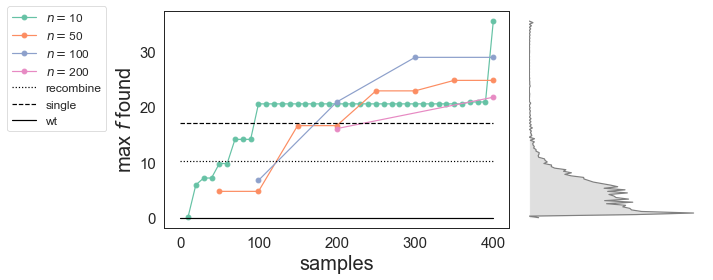

In [30]:
pal = sns.color_palette('Set2')
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios':[2, 1]}, figsize=(10, 4))


ax = axs[1]
f = df['f'].values
p = df['sorted'].values
inds = list(np.argsort(f))
thinned = inds[:-1000:10] + inds[-1000:]
f_thinned = f[thinned] 
p_thinned = p[thinned] 
_ = sns.kdeplot(f, vertical=True, shade=True, color='grey')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_axis_off()


ax = axs[0]

for n, c in zip([10, 50, 100, 200], pal):
    col = 'round' + str(n)
    dat = df[df[col] != -1]
    rounds = np.array(sorted(set(df[col]))[1:])
    rounds += 1
    xs = n * rounds
    ys = [np.max(dat[dat[col] <= r - 1]['f'].values) for r in rounds]
    ax.plot(xs, ys, 'o-', label=r'$n=$' + str(n), color=c)
    

_ = ax.plot([-0.5, 400], [df[df['baseline'] == 1]['f'].values] * 2, ':', label='recombine', color='black')
_ = ax.plot([-0.5, 400], [np.max(10 ** y[single_inds])] * 2, '--', color='black', label='single')
_ = ax.plot([-0.5, 400], [np.max(10 ** y[wt_inds])] * 2, color='black', label='wt')


ax.legend(bbox_to_anchor=(-0.15, 1.05))
_ = ax.set_xlabel('samples')
_ = ax.set_ylabel(r'max $f$ found')
_ = fig.tight_layout()
_ = fig.savefig('../outputs/phoq_maxes.pdf')

In [35]:


for n in [10]:
    np.random.seed(125120)
    _ = torch.manual_seed(43298)




    singles = [wt[:i] + aas[j] + wt[i+1:] for i in range(4) for j in range(20)]
    wt_inds = [seq_to_x[wt]]
    single_inds = wt_inds + [seq_to_x[seq] for seq in singles]
    train_inds = wt_inds + list(np.random.choice(len(X), n, replace=True)) # + single_inds


    y_true = y
    A_test = A

    sampled_inds = [train_inds[:]]
    libs = []
    objs = []

    rounds = 400 // n - 1

    for it in range(rounds):
        inds = sorted(set(train_inds))
        print(len(inds))
        dic, _ = helpers.get_predictions(A[inds], y[inds], A_test,
                                         one_hots=X, its=3000, lr=1e-2)
        print()
        seen_seqs = [helpers.decode_X(X[i]) for i in inds]
        for s in seen_seqs:
            dic[s] = 0.0
        seed = helpers.get_seed(dic)
        sets_seed, objs_seed = opt.greedy_add(ground, seed, objectives.objective, obj_args=(L, dic, n))
        sets_grou, objs_grou = opt.greedy_add(ground, ground, objectives.objective, obj_args=(L, dic, n))
        if objs_grou[-1] < objs_seed[-1]:
            X_new = sets_grou[-1]
            objs.append(objs_grou[-1])
        else:
            X_new = sets_seed[-1]
            objs.append(objs_seed[-1])
        new_lib = helpers.seqs_from_set(X_new, L)
        inds = np.random.choice(len(new_lib), n, replace=True)
        sampled_seqs = [new_lib[i] for i in inds]
        inds = [seq_to_x[s] for s in sampled_seqs]
        sampled_inds.append(inds)
        train_inds += inds
        libs.append(X_new)

    df = pd.DataFrame(10 ** y, columns=['f'])
    df['round'] = [-1 for _ in df.index]
    for r, inds in enumerate(sampled_inds):
        for i in inds:
            if df.loc[i, 'round'] == -1:
                df.loc[i, 'round'] = r

    df['single'] = [1 if i in single_inds else 0 for i in df.index]
    df['wt'] = [0 for i in df.index]
    df.loc[wt_inds]['wt'] = 1
    df['sorted'] = np.linspace(0, 1, len(y))[np.argsort(np.argsort(df['f']))]
    df['baseline'] = [0 for _ in df.index]
    baseline = ''
    for i in range(4):
        seqs = [wt[:i] + a + wt[i + 1:] for a in aas]
        inds = [seq_to_x[s] for s in seqs]
        baseline += aas[np.argmax(y[inds])]
    df.loc[seq_to_x[baseline], 'baseline'] = 1

    results = {
        'df':df,
        'sampled_inds': sampled_inds,
        'libs':libs,
        'objs': objs
    }

    with open('../outputs/20181018_phoq_batches_add' + str(rounds + 1) + '.pkl', 'wb') as f:
        pickle.dump(results, f)

    

11
Iteration 3000 of 3000	NLML: 5.5000	sn: 0.022247	
20
Iteration 3000 of 3000	NLML: 6.5723	sn: 0.000001	
27
Iteration 3000 of 3000	NLML: 11.6925	sn: 0.000001	
34
Iteration 3000 of 3000	NLML: 15.2089	sn: 0.307788	
42
Iteration 3000 of 3000	NLML: 15.6688	sn: 0.334883	
52
Iteration 3000 of 3000	NLML: 19.4686	sn: 0.265949	
59
Iteration 3000 of 3000	NLML: 19.1092	sn: 0.215025	
65
Iteration 3000 of 3000	NLML: 19.3407	sn: 0.194976	
74
Iteration 3000 of 3000	NLML: 17.1341	sn: 0.158873	
81
Iteration 3000 of 3000	NLML: 14.6166	sn: 0.138830	
87
Iteration 3000 of 3000	NLML: 14.8092	sn: 0.133515	
95
Iteration 3000 of 3000	NLML: 18.4596	sn: 0.133678	
100
Iteration 3000 of 3000	NLML: 15.7491	sn: 0.119094	
106
Iteration 3000 of 3000	NLML: 14.8284	sn: 0.116524	
115
Iteration 3000 of 3000	NLML: 13.5926	sn: 0.108073	
121
Iteration 3000 of 3000	NLML: 11.2991	sn: 0.096352	
128
Iteration 3000 of 3000	NLML: 10.4070	sn: 0.092639	
137
Iteration 3000 of 3000	NLML: 13.9101	sn: 0.096697	
139
Iteration 3000 of 30

In [36]:


for n in [10]:
    np.random.seed(125120)
    _ = torch.manual_seed(43298)




    singles = [wt[:i] + aas[j] + wt[i+1:] for i in range(4) for j in range(20)]
    wt_inds = [seq_to_x[wt]]
    single_inds = wt_inds + [seq_to_x[seq] for seq in singles]
    train_inds = wt_inds + list(np.random.choice(len(X), n, replace=True)) # + single_inds


    y_true = y
    A_test = A

    sampled_inds = [train_inds[:]]
    libs = []
    objs = []

    rounds = 400 // n - 1

    for it in range(rounds):
        inds = sorted(set(train_inds))
        print(len(inds))
        dic, _ = helpers.get_predictions(A[inds], y[inds], A_test,
                                         one_hots=X, its=3000, lr=1e-2)
        print()
        seen_seqs = [helpers.decode_X(X[i]) for i in inds]
        for s in seen_seqs:
            dic[s] = 0.0
        seed = helpers.get_seed(dic)
        sets_seed, objs_seed = opt.greedy_add(ground, seed, objectives.objective, obj_args=(L, dic, n), remove=True)
        sets_grou, objs_grou = opt.greedy_add(ground, ground, objectives.objective, obj_args=(L, dic, n), remove=True)
        if objs_grou[-1] < objs_seed[-1]:
            X_new = sets_grou[-1]
            objs.append(objs_grou[-1])
        else:
            X_new = sets_seed[-1]
            objs.append(objs_seed[-1])
        new_lib = helpers.seqs_from_set(X_new, L)
        inds = np.random.choice(len(new_lib), n, replace=True)
        sampled_seqs = [new_lib[i] for i in inds]
        inds = [seq_to_x[s] for s in sampled_seqs]
        sampled_inds.append(inds)
        train_inds += inds
        libs.append(X_new)

    df = pd.DataFrame(10 ** y, columns=['f'])
    df['round'] = [-1 for _ in df.index]
    for r, inds in enumerate(sampled_inds):
        for i in inds:
            if df.loc[i, 'round'] == -1:
                df.loc[i, 'round'] = r

    df['single'] = [1 if i in single_inds else 0 for i in df.index]
    df['wt'] = [0 for i in df.index]
    df.loc[wt_inds]['wt'] = 1
    df['sorted'] = np.linspace(0, 1, len(y))[np.argsort(np.argsort(df['f']))]
    df['baseline'] = [0 for _ in df.index]
    baseline = ''
    for i in range(4):
        seqs = [wt[:i] + a + wt[i + 1:] for a in aas]
        inds = [seq_to_x[s] for s in seqs]
        baseline += aas[np.argmax(y[inds])]
    df.loc[seq_to_x[baseline], 'baseline'] = 1

    results = {
        'df':df,
        'sampled_inds': sampled_inds,
        'libs':libs,
        'objs': objs
    }

    with open('../outputs/20181018_phoq_batches_rem' + str(rounds + 1) + '.pkl', 'wb') as f:
        pickle.dump(results, f)

    

11
Iteration 3000 of 3000	NLML: 5.5000	sn: 0.022247	
20
Iteration 3000 of 3000	NLML: 8.1823	sn: 0.000001	
27
Iteration 3000 of 3000	NLML: 6.1306	sn: 0.000001	
34
Iteration 3000 of 3000	NLML: 12.4769	sn: 0.000001	
41
Iteration 3000 of 3000	NLML: 15.9113	sn: 0.000001	
50
Iteration 3000 of 3000	NLML: 19.2144	sn: 0.252221	
60
Iteration 3000 of 3000	NLML: 19.0723	sn: 0.222357	
67
Iteration 3000 of 3000	NLML: 17.4442	sn: 0.144019	
74
Iteration 3000 of 3000	NLML: 14.2441	sn: 0.101317	
81
Iteration 3000 of 3000	NLML: 11.3872	sn: 0.085623	
87
Iteration 3000 of 3000	NLML: 8.6234	sn: 0.067904		
95
Iteration 3000 of 3000	NLML: 8.2880	sn: 0.071563		
102
Iteration 3000 of 3000	NLML: 9.4697	sn: 0.078848		
109
Iteration 3000 of 3000	NLML: 10.6372	sn: 0.065879	
115
Iteration 3000 of 3000	NLML: 10.3529	sn: 0.063843	
124
Iteration 3000 of 3000	NLML: 6.1796	sn: 0.032130	
134
Iteration 3000 of 3000	NLML: 10.7023	sn: 0.039990	
142
Iteration 3000 of 3000	NLML: 11.2940	sn: 0.040654	
149
Iteration 3000 of 3000

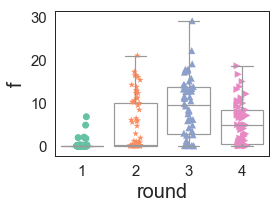

In [39]:
pal = sns.color_palette('Set2')

fnames = ['../outputs/20181018_phoq_batches4.pkl']

out_names = ['dsopt']
for out_name, fname in zip(out_names, fnames):
    with open(fname, 'rb') as f:
        results = pickle.load(f)
    df = results['df']
    df['round'] += 1

    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    for mark, r in zip(['o', '*', '^', '>'], range(1, 5)):
        dat = df[df['round'] == r]
        temp = pd.DataFrame(np.array([[1, 2, 3, 4]]).T, columns=['round'])
        dat = dat.append(temp)
        if r == 0:
            s = 5
        else:
            s = 7
        ax = sns.boxplot(data=dat, x='round', y='f', color='white', ax=ax, fliersize=0)
        ax = sns.stripplot(data=dat, x='round', y='f', color=pal[r-1], ax=ax, marker=mark, size=s, zorder=1)

#     _ = ax.plot([-0.5, 3.5], [df[df['baseline'] == 1]['f'].values] * 2, ':', label='recombine', color='black')
#     _ = ax.plot([-0.5, 3.5], [np.max(10 ** y[single_inds])] * 2, '--', color='black', label='single')
#     _ = ax.plot([-0.5, 3.5], [np.max(10 ** y[wt_inds])] * 2, color='black', label='wt')
#     _ = ax.legend(frameon=True)
    _ = fig.tight_layout()
    _ = fig.savefig('../outputs/phoq_batches' + out_name + '.pdf')